In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [3]:
# Thêm cell này sau cell training để install ROUGE
!pip install rouge-score
!pip install matplotlib seaborn

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=4f1bbe6012938f3523f938ec4eda37bc66172abef3dc4746f10fc9266405b386
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [1]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)

# DoRA - Hiệu suất cao hơn LoRA truyền thống
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_dora = True,  # Bật DoRA
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-06-01 11:48:17.281238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748778497.303343    2345 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748778497.310240    2345 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.5.9 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Already have LoRA adapters! We shall skip this step.


In [3]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("philschmid/guanaco-sharegpt-style", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

dataset[5]["conversations"]

print(dataset[5]["text"])

unsloth_template = \
    "{{ bos_token }}"\
    "{{ 'You are a helpful assistant to the user\n' }}"\
    "{% for message in messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ '>>> User: ' + message['content'] + '\n' }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ '>>> Assistant: ' + message['content'] + eos_token + '\n' }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}"\
        "{{ '>>> Assistant: ' }}"\
    "{% endif %}"
unsloth_eos_token = "eos_token"

if False:
    tokenizer = get_chat_template(
        tokenizer,
        chat_template = (unsloth_template, unsloth_eos_token,), # You must provide a template and EOS token
        mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
        map_eos_token = True, # Maps <|im_end|> to </s> instead
    )

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the typical wattage of bulb in a lightbox?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The typical wattage of a bulb in a lightbox is 60 watts, although domestic LED bulbs are normally much lower than 60 watts, as they produce the same or greater lumens for less wattage than alternatives. A 60-watt Equivalent LED bulb can be calculated using the 7:1 ratio, which divides 60 watts by 7 to get roughly 9 watts.<|eot_id|><|start_header_id|>user<|end_header_id|>

Rewrite your description of the typical wattage of a bulb in a lightbox to only include the key points in a list format.<|eot_id|>


In [4]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3", 
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)

from datasets import load_dataset

cnn_dm_dataset = load_dataset('cnn_dailymail', '3.0.0')

def format_cnn_dm_for_chat(examples):
    texts = []
    for article, summary in zip(examples['article'], examples['highlights']):
        article_words = article.split()
        if len(article_words) > 800:
            article = " ".join(article_words[:800]) + "..."
        
        conversation = [
            {"from": "human", "value": f"Please summarize the following article:\n\n{article}"},
            {"from": "gpt", "value": summary}
        ]
        
        text = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=False)
        texts.append(text)
    
    return {"text": texts}

total_size = len(cnn_dm_dataset['train'])
sample_size = int(0.01 * total_size)  
subset_dataset = cnn_dm_dataset['train'].select(range(sample_size))

formatted_dataset = subset_dataset.map(format_cnn_dm_for_chat, batched=True)

print("Sample đã được format:")
print("="*80)
sample_text = formatted_dataset[0]['text']
print(sample_text[:500] + "..." if len(sample_text) > 500 else sample_text)
print("="*80)

train_size = int(0.9 * len(formatted_dataset))
train_dataset = formatted_dataset.select(range(train_size))
val_dataset = formatted_dataset.select(range(train_size, len(formatted_dataset)))

print(f"\nTotal original dataset size: {total_size}")
print(f"Using 1% subset size: {sample_size}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Kiểm tra độ dài sequence
import numpy as np

def check_sequence_lengths(dataset, num_samples=10):
    lengths = []
    for i in range(min(num_samples, len(dataset))):
        tokens = tokenizer.encode(dataset[i]['text'])
        lengths.append(len(tokens))
    
    print(f"\nSequence length statistics (first {num_samples} samples):")
    print(f"Min length: {min(lengths)}")
    print(f"Max length: {max(lengths)}")
    print(f"Average length: {np.mean(lengths):.1f}")
    print(f"Median length: {np.median(lengths):.1f}")

check_sequence_lengths(train_dataset)

Sample đã được format:
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Please summarize the following article:

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his ca...

Total original dataset size: 287113
Using 1% subset size: 2871
Train dataset size: 2583
Validation dataset size: 288

Sequence length statistics (first 10 samples):
Min length: 509
Max length: 1055
Average length: 800.2
Median length: 827.5


In [5]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import os

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
max_seq_length = 2048
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 1,
        warmup_steps = 5,
        max_steps = 30,  
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = [],  
        dataloader_drop_last = True, 
    ),
)

print("Trainer được setup thành công cho summarization task!")
print(f"Sẽ training {100} steps với batch size {2} và gradient accumulation {2}")
print(f"Effective batch size: {2 * 2} = 4")

Trainer được setup thành công cho summarization task!
Sẽ training 100 steps với batch size 2 và gradient accumulation 2
Effective batch size: 4 = 4


In [6]:
print("=== BẮT ĐẦU TRAINING ===")
print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: 4")
print(f"Total steps: 50")
print("=" * 50)

trainer_stats = trainer.train()

print("\n=== TRAINING HOÀN THÀNH ===")
print(f"Training loss: {trainer_stats.training_loss:.4f}")
print(f"Total training time: {trainer_stats.metrics.get('train_runtime', 'N/A')} seconds")

=== BẮT ĐẦU TRAINING ===
Dataset size: 2583
Batch size: 4
Total steps: 50


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,583 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 43,319,296/8,000,000,000 (0.54% trained)


Step,Training Loss
10,2.230100
20,2.082800
30,2.012100


Unsloth: Will smartly offload gradients to save VRAM!

=== TRAINING HOÀN THÀNH ===
Training loss: 2.1083
Total training time: 261.0694 seconds


In [7]:
# Cell test model - cập nhật để test summarization
# Test model với một vài sample
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# Load một vài sample từ validation set của CNN/DailyMail để test
test_articles = [
    "Scientists have discovered a new species of deep-sea fish in the Pacific Ocean. The fish, found at depths of over 3000 meters, has unique bioluminescent properties that help it navigate in the dark waters. Researchers believe this discovery could lead to new insights about marine biodiversity and evolution.",
    
    "The stock market experienced significant volatility today as investors reacted to new economic data. Technology stocks led the decline, with major companies seeing drops of up to 5%. Market analysts suggest the volatility is related to concerns about inflation and interest rate policies.",
    
    "A breakthrough in renewable energy technology has been announced by researchers at MIT. The new solar panel design can achieve 40% efficiency, significantly higher than current commercial panels. This advancement could make solar energy more cost-effective and accelerate the transition to clean energy."
]

print("=== TESTING SUMMARIZATION MODEL ===\n")

for i, article in enumerate(test_articles, 1):
    print(f"Test {i}:")
    print("Article:", article[:100] + "..." if len(article) > 100 else article)
    
    messages = [
        {"role": "user", "content": f"Please summarize the following article:\n\n{article}"}
    ]
    
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt"
    ).to("cuda")
    
    outputs = model.generate(
        input_ids = inputs, 
        max_new_tokens = 100,  
        use_cache = True,
        temperature = 0.3,  
        do_sample = True,
        pad_token_id = tokenizer.eos_token_id
    )
    
    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    print("Summary:", response.strip())
    print("-" * 80)
    print()

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


=== TESTING SUMMARIZATION MODEL ===

Test 1:
Article: Scientists have discovered a new species of deep-sea fish in the Pacific Ocean. The fish, found at d...
Summary: Scientists have discovered a new species of deep-sea fish in the Pacific Ocean. The fish, found at depths of over 3000 meters, has unique bioluminescent properties that help it navigate in the dark waters. Researchers believe this discovery could lead to new insights about marine biodiversity and evolution.
--------------------------------------------------------------------------------

Test 2:
Article: The stock market experienced significant volatility today as investors reacted to new economic data....
Summary: The stock market experienced significant volatility today as investors reacted to new economic data. Technology stocks led the decline, with major companies seeing drops of up to 5%. Market analysts suggest the volatility is related to concerns about inflation and interest rate policies.
-----------------------

In [8]:
# Cell để chuẩn bị evaluation cho summarization
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
import pandas as pd
from datasets import load_dataset

# Setup ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_summarization_rouge(model, tokenizer, test_data, max_samples=50):
    """
    Evaluate model summarization using ROUGE scores
    """
    print(f"Evaluating on {len(test_data)} samples...")
    
    predictions = []
    references = []
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    # Set model to inference mode
    FastLanguageModel.for_inference(model)
    
    for i, sample in enumerate(test_data):
        if i >= max_samples:
            break
            
        # Extract article and reference summary from CNN/DM format
        article = sample['article']
        reference_summary = sample['highlights']
        
        # Truncate article if too long
        article_words = article.split()
        if len(article_words) > 400:  # Shorter for evaluation
            article = " ".join(article_words[:400]) + "..."
        
        # Generate summary
        messages = [
            {"role": "user", "content": f"Please summarize the following article:\n\n{article}"}
        ]
        
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to("cuda")
        
        try:
            outputs = model.generate(
                input_ids=inputs,
                max_new_tokens=100,
                use_cache=True,
                temperature=0.3,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )
            
            predicted_summary = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True).strip()
            
            # Calculate ROUGE scores
            scores = scorer.score(reference_summary, predicted_summary)
            
            # Store results
            predictions.append(predicted_summary)
            references.append(reference_summary)
            
            rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
            rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
            rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)
            
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{min(max_samples, len(test_data))} samples")
                
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue
    
    return predictions, references, rouge_scores

# Prepare test dataset từ CNN/DailyMail validation set
print("Loading CNN/DailyMail validation dataset for evaluation...")
test_dataset = load_dataset('cnn_dailymail', '3.0.0', split='validation')
test_samples = test_dataset.select(range(50))  # Use 50 samples for evaluation

print(f"Prepared {len(test_samples)} test samples")

Loading CNN/DailyMail validation dataset for evaluation...
Prepared 50 test samples


In [9]:
# Cell để evaluate model TRƯỚC khi fine-tune
print("=== EVALUATING BEFORE FINE-TUNING ===")

# Evaluate model trước khi fine-tune
predictions_before, references_before, rouge_before = evaluate_summarization_rouge(
    model, tokenizer, test_samples, max_samples=50
)

# Calculate average scores
avg_rouge_before = {
    'rouge1': np.mean(rouge_before['rouge1']),
    'rouge2': np.mean(rouge_before['rouge2']),
    'rougeL': np.mean(rouge_before['rougeL'])
}

print("\nROUGE Scores BEFORE Fine-tuning:")
print(f"ROUGE-1: {avg_rouge_before['rouge1']:.4f}")
print(f"ROUGE-2: {avg_rouge_before['rouge2']:.4f}")
print(f"ROUGE-L: {avg_rouge_before['rougeL']:.4f}")

# Show some examples
print("\nSample predictions BEFORE fine-tuning:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Reference: {references_before[i][:100]}...")
    print(f"Prediction: {predictions_before[i][:100]}...")
    print("-" * 50)

=== EVALUATING BEFORE FINE-TUNING ===
Evaluating on 50 samples...
Processed 10/50 samples
Processed 20/50 samples
Processed 30/50 samples
Processed 40/50 samples
Processed 50/50 samples

ROUGE Scores BEFORE Fine-tuning:
ROUGE-1: 0.3174
ROUGE-2: 0.1224
ROUGE-L: 0.2240

Sample predictions BEFORE fine-tuning:

Example 1:
Reference: Zully Broussard decided to give a kidney to a stranger .
A new computer program helped her donation ...
Prediction: Zully Broussard selflessly gave a kidney to a stranger.
The kidney was then used in a chain of trans...
--------------------------------------------------

Example 2:
Reference: The 20th MLS season begins this weekend .
League has changed dramatically since its inception in 199...
Prediction: (CNN) -- The first ever Major League Soccer match took place on April 6, 1996. The San Jose Clash an...
--------------------------------------------------

Example 3:
Reference: Bafetimbi Gomis collapses within 10 minutes of kickoff at Tottenham .
But he repo

In [10]:
# Cell để evaluate model SAU khi fine-tune (thêm sau cell training)
print("=== EVALUATING AFTER FINE-TUNING ===")

# Evaluate model sau khi fine-tune
predictions_after, references_after, rouge_after = evaluate_summarization_rouge(
    model, tokenizer, test_samples, max_samples=50
)

# Calculate average scores
avg_rouge_after = {
    'rouge1': np.mean(rouge_after['rouge1']),
    'rouge2': np.mean(rouge_after['rouge2']),
    'rougeL': np.mean(rouge_after['rougeL'])
}

print("\nROUGE Scores AFTER Fine-tuning:")
print(f"ROUGE-1: {avg_rouge_after['rouge1']:.4f}")
print(f"ROUGE-2: {avg_rouge_after['rouge2']:.4f}")
print(f"ROUGE-L: {avg_rouge_after['rougeL']:.4f}")

print("\nImprovement:")
print(f"ROUGE-1: +{avg_rouge_after['rouge1'] - avg_rouge_before['rouge1']:.4f}")
print(f"ROUGE-2: +{avg_rouge_after['rouge2'] - avg_rouge_before['rouge2']:.4f}")
print(f"ROUGE-L: +{avg_rouge_after['rougeL'] - avg_rouge_before['rougeL']:.4f}")

# Show some examples
print("\nSample predictions AFTER fine-tuning:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Reference: {references_after[i][:100]}...")
    print(f"Before: {predictions_before[i][:100]}...")
    print(f"After: {predictions_after[i][:100]}...")
    print("-" * 50)

=== EVALUATING AFTER FINE-TUNING ===
Evaluating on 50 samples...
Processed 10/50 samples
Processed 20/50 samples
Processed 30/50 samples
Processed 40/50 samples
Processed 50/50 samples

ROUGE Scores AFTER Fine-tuning:
ROUGE-1: 0.3095
ROUGE-2: 0.1210
ROUGE-L: 0.2193

Improvement:
ROUGE-1: +-0.0079
ROUGE-2: +-0.0014
ROUGE-L: +-0.0047

Sample predictions AFTER fine-tuning:

Example 1:
Reference: Zully Broussard decided to give a kidney to a stranger .
A new computer program helped her donation ...
Before: Zully Broussard selflessly gave a kidney to a stranger.
The kidney was then used in a chain of trans...
After: Broussard's kidney donation led to 6 transplants
She donated to a stranger, but her gift multiplied
...
--------------------------------------------------

Example 2:
Reference: The 20th MLS season begins this weekend .
League has changed dramatically since its inception in 199...
Before: (CNN) -- The first ever Major League Soccer match took place on April 6, 1996. The San Jose

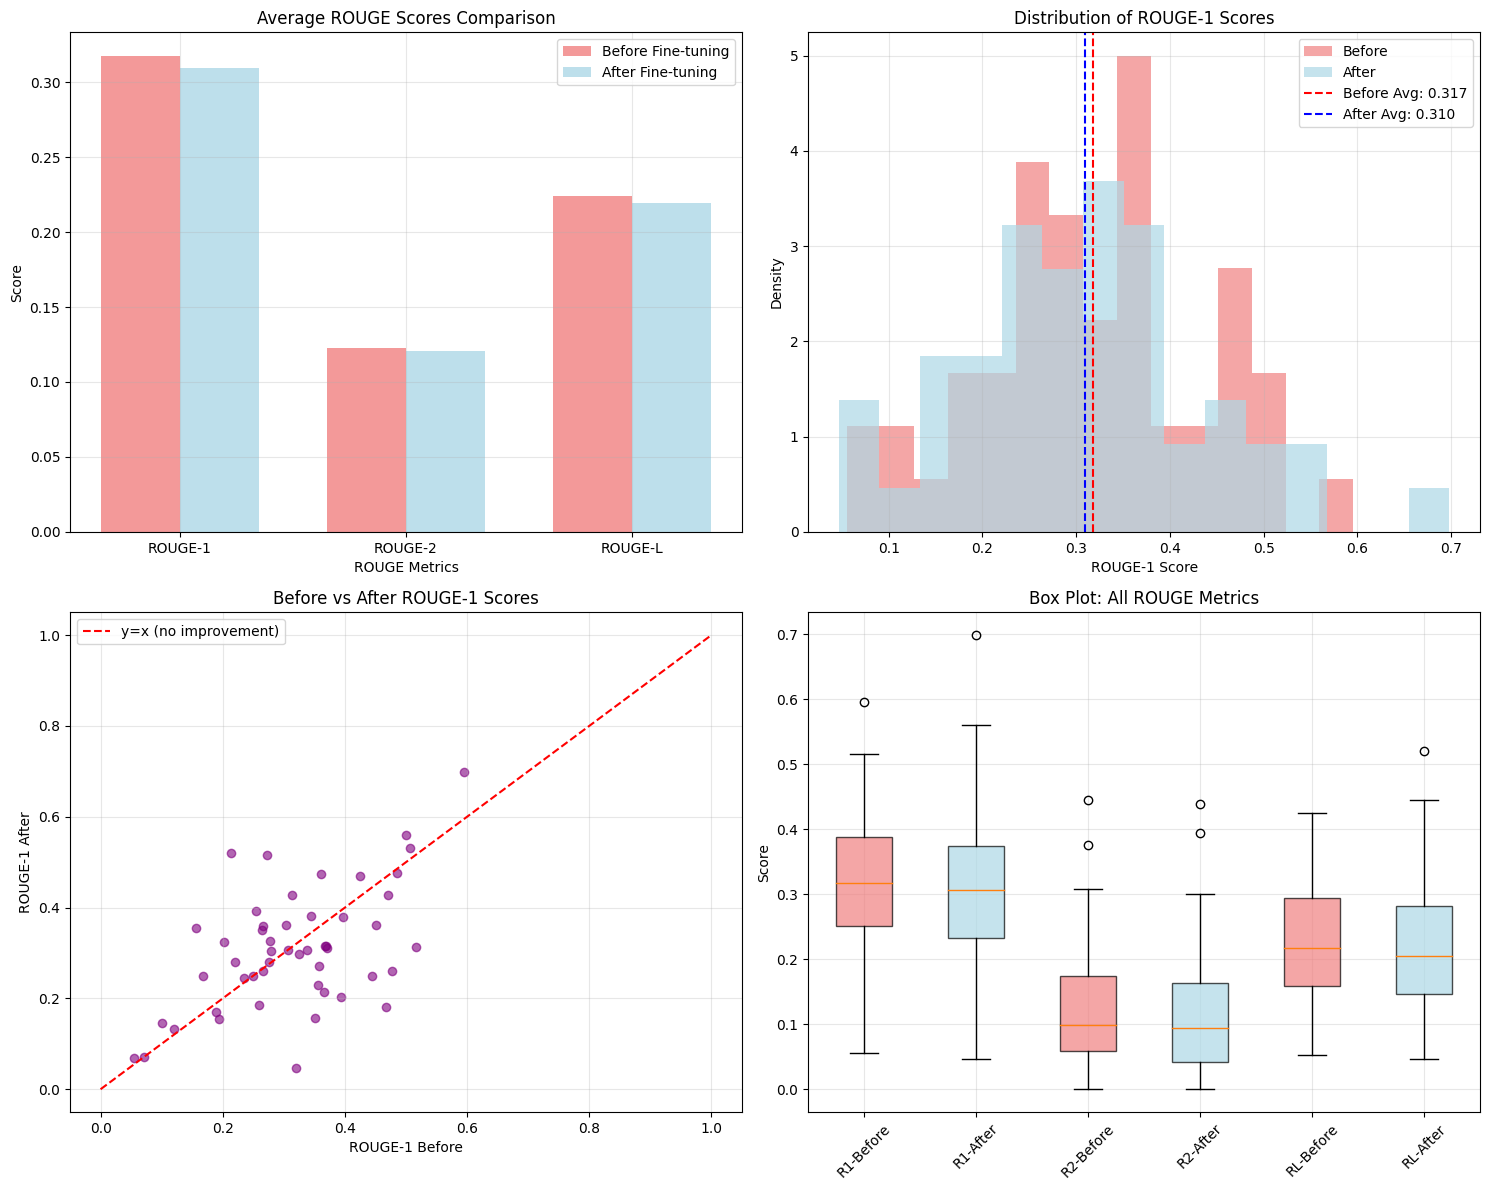


DETAILED EVALUATION RESULTS

Number of test samples: 50

BEFORE Fine-tuning:
  ROUGE-1: 0.3174 ± 0.1204
  ROUGE-2: 0.1224 ± 0.0972
  ROUGE-L: 0.2240 ± 0.0904

AFTER Fine-tuning:
  ROUGE-1: 0.3095 ± 0.1326
  ROUGE-2: 0.1210 ± 0.1033
  ROUGE-L: 0.2193 ± 0.1034

IMPROVEMENT:
  ROUGE-1: -0.0079
  ROUGE-2: -0.0014
  ROUGE-L: -0.0047

PERCENTAGE IMPROVEMENT:
  ROUGE-1: -2.49%
  ROUGE-2: -1.17%
  ROUGE-L: -2.11%

SAMPLES WITH IMPROVEMENT:
  ROUGE-1: 24/50 (48.0%)
  ROUGE-2: 22/50 (44.0%)
  ROUGE-L: 22/50 (44.0%)


In [11]:
# Cell để vẽ đồ thị so sánh ROUGE scores
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Bar chart comparing average ROUGE scores
rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
before_scores = [avg_rouge_before['rouge1'], avg_rouge_before['rouge2'], avg_rouge_before['rougeL']]
after_scores = [avg_rouge_after['rouge1'], avg_rouge_after['rouge2'], avg_rouge_after['rougeL']]

x = np.arange(len(rouge_metrics))
width = 0.35

axes[0, 0].bar(x - width/2, before_scores, width, label='Before Fine-tuning', color='lightcoral', alpha=0.8)
axes[0, 0].bar(x + width/2, after_scores, width, label='After Fine-tuning', color='lightblue', alpha=0.8)
axes[0, 0].set_xlabel('ROUGE Metrics')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Average ROUGE Scores Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(rouge_metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of ROUGE-1 scores
axes[0, 1].hist(rouge_before['rouge1'], bins=15, alpha=0.7, label='Before', color='lightcoral', density=True)
axes[0, 1].hist(rouge_after['rouge1'], bins=15, alpha=0.7, label='After', color='lightblue', density=True)
axes[0, 1].axvline(avg_rouge_before['rouge1'], color='red', linestyle='--', label=f'Before Avg: {avg_rouge_before["rouge1"]:.3f}')
axes[0, 1].axvline(avg_rouge_after['rouge1'], color='blue', linestyle='--', label=f'After Avg: {avg_rouge_after["rouge1"]:.3f}')
axes[0, 1].set_xlabel('ROUGE-1 Score')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Distribution of ROUGE-1 Scores')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot: Before vs After scores
axes[1, 0].scatter(rouge_before['rouge1'], rouge_after['rouge1'], alpha=0.6, color='purple')
axes[1, 0].plot([0, 1], [0, 1], 'r--', label='y=x (no improvement)')
axes[1, 0].set_xlabel('ROUGE-1 Before')
axes[1, 0].set_ylabel('ROUGE-1 After')
axes[1, 0].set_title('Before vs After ROUGE-1 Scores')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot for all ROUGE metrics
data_to_plot = [
    rouge_before['rouge1'], rouge_after['rouge1'],
    rouge_before['rouge2'], rouge_after['rouge2'],
    rouge_before['rougeL'], rouge_after['rougeL']
]
labels = ['R1-Before', 'R1-After', 'R2-Before', 'R2-After', 'RL-Before', 'RL-After']
colors = ['lightcoral', 'lightblue', 'lightcoral', 'lightblue', 'lightcoral', 'lightblue']

bp = axes[1, 1].boxplot(data_to_plot, labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Box Plot: All ROUGE Metrics')
axes[1, 1].grid(True, alpha=0.3)
plt.setp(axes[1, 1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("DETAILED EVALUATION RESULTS")
print("="*60)

print(f"\nNumber of test samples: {len(rouge_before['rouge1'])}")

print("\nBEFORE Fine-tuning:")
print(f"  ROUGE-1: {avg_rouge_before['rouge1']:.4f} ± {np.std(rouge_before['rouge1']):.4f}")
print(f"  ROUGE-2: {avg_rouge_before['rouge2']:.4f} ± {np.std(rouge_before['rouge2']):.4f}")
print(f"  ROUGE-L: {avg_rouge_before['rougeL']:.4f} ± {np.std(rouge_before['rougeL']):.4f}")

print("\nAFTER Fine-tuning:")
print(f"  ROUGE-1: {avg_rouge_after['rouge1']:.4f} ± {np.std(rouge_after['rouge1']):.4f}")
print(f"  ROUGE-2: {avg_rouge_after['rouge2']:.4f} ± {np.std(rouge_after['rouge2']):.4f}")
print(f"  ROUGE-L: {avg_rouge_after['rougeL']:.4f} ± {np.std(rouge_after['rougeL']):.4f}")

print("\nIMPROVEMENT:")
print(f"  ROUGE-1: {avg_rouge_after['rouge1'] - avg_rouge_before['rouge1']:+.4f}")
print(f"  ROUGE-2: {avg_rouge_after['rouge2'] - avg_rouge_before['rouge2']:+.4f}")
print(f"  ROUGE-L: {avg_rouge_after['rougeL'] - avg_rouge_before['rougeL']:+.4f}")

# Calculate percentage improvement
print("\nPERCENTAGE IMPROVEMENT:")
print(f"  ROUGE-1: {((avg_rouge_after['rouge1'] - avg_rouge_before['rouge1']) / avg_rouge_before['rouge1'] * 100):+.2f}%")
print(f"  ROUGE-2: {((avg_rouge_after['rouge2'] - avg_rouge_before['rouge2']) / avg_rouge_before['rouge2'] * 100):+.2f}%")
print(f"  ROUGE-L: {((avg_rouge_after['rougeL'] - avg_rouge_before['rougeL']) / avg_rouge_before['rougeL'] * 100):+.2f}%")

# Count improvements
improvements = {
    'rouge1': sum(1 for i in range(len(rouge_before['rouge1'])) if rouge_after['rouge1'][i] > rouge_before['rouge1'][i]),
    'rouge2': sum(1 for i in range(len(rouge_before['rouge2'])) if rouge_after['rouge2'][i] > rouge_before['rouge2'][i]),
    'rougeL': sum(1 for i in range(len(rouge_before['rougeL'])) if rouge_after['rougeL'][i] > rouge_before['rougeL'][i])
}

print("\nSAMPLES WITH IMPROVEMENT:")
total_samples = len(rouge_before['rouge1'])
print(f"  ROUGE-1: {improvements['rouge1']}/{total_samples} ({improvements['rouge1']/total_samples*100:.1f}%)")
print(f"  ROUGE-2: {improvements['rouge2']}/{total_samples} ({improvements['rouge2']/total_samples*100:.1f}%)")
print(f"  ROUGE-L: {improvements['rougeL']}/{total_samples} ({improvements['rougeL']/total_samples*100:.1f}%)")

In [3]:
!nvidia-smi

Wed May 28 06:29:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----